## dataload & FeatureEngineering

In [46]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
plt.style.use('seaborn')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import missingno
import pandas as pd
pd.set_option('display.min_rows', 500)
import warnings
warnings.filterwarnings('ignore')

def concat_and_export(train_fe, test_fe):
    
    train_fe['kind']='train'
    test_fe['kind']='test'
    
    df = pd.concat([train_fe,test_fe])
    data_dir = '/opt/ml/input/data' # 경로
    write_path=f'{data_dir}/after_fe_train_test_cumsum.pkl'
    df.to_pickle(write_path,index=False)
    print(f"Write: {write_path}")
    
def export(df, output='after_fe_train_test.pkl'):
    data_dir = '/opt/ml/input/data' # 경로
    write_path=f'{data_dir}/{output}'
    df.to_pickle(write_path)
    print(f"Write: {write_path}")
    
path='../../data/'
train = pd.read_csv(f"{path}/train_data.csv")
test = pd.read_csv(f"{path}/test_data.csv")

day_dict = {'Tuesday': 0,
 'Thursday': 1,
 'Monday': 2,
 'Saturday': 3,
 'Friday': 4,
 'Wednesday': 5,
 'Sunday': 6}

def feature_engineering(df):
    uid2idx = {v:k for k,v in enumerate(sorted(df.userID.unique()))}
    ass2idx = {v:k for k,v in enumerate(sorted(df.assessmentItemID.unique()))}
    test2idx = {v:k for k,v in enumerate(sorted(df.testId.unique()))}

    df2 = df.copy()
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    
    # userID, assessmentItemID, testId 라벨인코딩
    df2['uidIdx'] = df2.userID.map(uid2idx)
    df2['assIdx'] = df2.assessmentItemID.map(ass2idx)
    df2['testIdx'] = df2.testId.map(test2idx)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df2['user_correct_answer'] = df2.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df2['user_total_answer'] = df2.groupby('userID')['answerCode'].cumcount()
    df2['user_acc'] = df2['user_correct_answer']/df2['user_total_answer']
    df2['month'] = pd.to_datetime(df2.Timestamp).dt.month
    df2['day'] = pd.to_datetime(df2.Timestamp).dt.day
    df2['hour'] = pd.to_datetime(df2.Timestamp).dt.hour
    df2['dayname'] = pd.to_datetime(df2.Timestamp).dt.day_name().map(day_dict)
    df2['big_category'] = df2.testId.map(lambda x:x[2]).astype(int)
    df2['problem_num'] = df2.assessmentItemID.map(lambda x: int(x[-3:]))
    df2['mid_category'] = df2.testId.map(lambda x: int(x[-3:]))

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df2.groupby(['testId'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_t.columns = ["test_mean", "test_std", 'test_sum']
    correct_k = df2.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_std', 'tag_sum']

    df2 = pd.merge(df2, correct_t, on=['testId'], how="left")
    df2 = pd.merge(df2, correct_k, on=['KnowledgeTag'], how="left")
    
    # 유저별 문제푼 시간, solvesec_3600, time_category
    df2['Timestamp2'] = pd.to_datetime(df2.Timestamp)
    df2['solvetime'] = df2.groupby('userID')['Timestamp2'].diff().fillna(pd.Timedelta(seconds=0))
    df2['solvesec'] = df2.solvetime.map(lambda x : x.total_seconds())
    df2['solvesec_3600'] = df2.solvesec
    df2.loc[df2.solvesec>=3600,'solvesec_3600']=3600

    df2['time_category'] = ''
    tc = [0,5,7,10,60,600,1200,2400,3600]
    df2.loc[(df2.solvesec==0), 'time_category'] = "0 - [0,0]"
    for i in range(len(tc)-1):
        s,e = tc[i],tc[i+1]
        df2.loc[(df2.solvesec>s) & (df2.solvesec<=e),'time_category']=f"{i+1} - ({s}, {e}]"
    df2.loc[(df2.solvesec>=tc[-1]),'time_category'] = f"{i+2} - ({e}, )"
    timecat2idx={k:v for v,k in enumerate(sorted(df2.time_category.unique()))}
    df2['time_category'] = df2.time_category.map(timecat2idx)
    
    # 유저별 문제푼 시간 Cumsum
    df2['solvesec_cumsum'] = df2.groupby(['userID','testId'])['solvesec_3600'].cumsum()%3601
    df2['solvecumsum_category'] = ''
    tc = [0,5,7,10,60,600,1200,2400,3600,7200]
    df2.loc[(df2.solvesec_cumsum==0), 'solvecumsum_category'] = "0 - [0,0]"
    for i in range(len(tc)-1):
        s,e = tc[i],tc[i+1]
        df2.loc[(df2.solvesec_cumsum>s) & (df2.solvesec_cumsum<=e),'solvecumsum_category']=f"{i+1} - ({s}, {e}]"
    df2.loc[(df2.solvesec_cumsum>=tc[-1]),'solvecumsum_category'] = f"{i+2} - ({e}, )"
    solvecumsum_category2idx={k:v for v,k in enumerate(sorted(df2.solvecumsum_category.unique()))}
    df2['solvecumsum_category'] = df2.solvecumsum_category.map(solvecumsum_category2idx)
    
    ## big_category
    # big_category 전체 정답률, 표준편차
#     big_category_answermean = dict(df2.groupby("big_category").answerCode.mean())
#     big_category_answerstd = dict(df2.groupby("big_category").answerCode.std())
#     df2['big_category_acc'] = df2.big_category.map(big_category_answermean)
#     df2['big_category_std'] = df2.big_category.map(big_category_answerstd)

    # 유저별 big category 문제 푼 횟수, 맞춤 횟수, 누적 정답률
    df2['big_category_cumconut'] = df2.groupby(['userID','big_category']).answerCode.cumcount()
    df2['big_category_answer'] = df2.groupby(['userID','big_category']).answerCode.transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df2['big_category_user_cum_acc'] = (df2['big_category_answer'] / df2['big_category_cumconut']).fillna(0)
    
    # 유저별 정답률, 표준 편차 (마지막제출 제외)
#     df2_user_big_ans = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','big_category']).answerCode.mean().reset_index()
#     df2_user_big_ans.rename(columns={'answerCode':'big_category_user_acc'},inplace=True)
#     df2 = df2.merge(df2_user_big_ans,on=['userID','big_category'])
    
#     df2_user_big_ans_std = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','big_category']).answerCode.std().reset_index()
#     df2_user_big_ans_std.rename(columns={'answerCode':'big_category_user_std'},inplace=True)
#     df2 = df2.merge(df2_user_big_ans_std,on=['userID','big_category'])   
    
    ## mid_category
    # mid_category 전체 정답률, 표준편차
#     mid_category_answermean = dict(df2.groupby("mid_category").answerCode.mean())
#     mid_category_answerstd = dict(df2.groupby("mid_category").answerCode.std())
#     df2['mid_category_acc'] = df2.mid_category.map(mid_category_answermean)
#     df2['mid_category_std'] = df2.mid_category.map(mid_category_answerstd)

    # 유저별 mid category 문제 푼 횟수, 맞춤 횟수, 누적 정답률
    df2['mid_category_cumconut'] = df2.groupby(['userID','mid_category']).answerCode.cumcount()
    df2['mid_category_answer'] = df2.groupby(['userID','mid_category']).answerCode.transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df2['mid_category_user_cum_acc'] = (df2['mid_category_answer'] / df2['mid_category_cumconut']).fillna(0)

    # 유저별 정답률, 표준 편차 (마지막제출 제외)
#     df2_user_mid_ans = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','mid_category']).answerCode.mean().reset_index()
#     df2_user_mid_ans.rename(columns={'answerCode':'mid_category_user_acc'},inplace=True)
#     df2 = df2.merge(df2_user_mid_ans,on=['userID','mid_category'])

#     df2_user_mid_ans_std = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','mid_category']).answerCode.std().reset_index()
#     df2_user_mid_ans_std.rename(columns={'answerCode':'mid_category_user_std'},inplace=True)
#     df2 = df2.merge(df2_user_mid_ans_std,on=['userID','mid_category']) 


    ### 문항별 난이도
    ass_acc_dict = dict(df2[df2.answerCode!=-1].groupby('assessmentItemID').answerCode.mean())
    df2['ass_acc_mean'] = df2.assessmentItemID.map(ass_acc_dict)
    df2['ass_difficulty'] = 1 - df2['ass_acc_mean']
    
    ass_acc_std_dict = dict(df2[df2.answerCode!=-1].groupby('assessmentItemID').answerCode.std())
    df2['ass_acc_std'] = df2.assessmentItemID.map(ass_acc_std_dict)

    ### 문제 번호별 난이도
    pb_num_dict = dict(df2[df2.answerCode!=-1].groupby('problem_num').answerCode.mean())
    df2['pb_num_acc_mean'] = df2.problem_num.map(pb_num_dict)
    df2['pb_num_difficulty'] = 1 - df2['pb_num_acc_mean']
    
    pb_num_std_dict = dict(df2[df2.answerCode!=-1].groupby('problem_num').answerCode.std())
    df2['pb_num_acc_std'] = df2.problem_num.map(pb_num_std_dict)
    
    ## assess_count
    df2['assess_count'] = df2.groupby(['userID','assessmentItemID']).answerCode.cumcount()
    
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    return df2

train['kind']='train'
test['kind']='test'
df = pd.concat([train,test])
df = feature_engineering(df)
df2=df.copy()

In [47]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2526700 entries, 0 to 2526699
Data columns (total 46 columns):
 #   Column                     Dtype          
---  ------                     -----          
 0   userID                     int64          
 1   assessmentItemID           object         
 2   testId                     object         
 3   answerCode                 int64          
 4   Timestamp                  object         
 5   KnowledgeTag               int64          
 6   kind                       object         
 7   uidIdx                     int64          
 8   assIdx                     int64          
 9   testIdx                    int64          
 10  user_correct_answer        float64        
 11  user_total_answer          int64          
 12  user_acc                   float64        
 13  month                      int64          
 14  day                        int64          
 15  hour                       int64          
 16  dayname           

## elo
Reference: https://www.kaggle.com/code/stevemju/riiid-simple-elo-rating/notebook

In [3]:
from tqdm import tqdm

### Description

* `theta` represents the global level of the student
* `beta` represents the difficulty of the item (items are represented by `content_id` in that case but you could change it by modifying the `granularity_feature_name` parameters)
* `left_asymptote` represents the probability of correctly answering a question by chance. The `correct_answer` from the questions dataset has 4 possible values, so this probability is at least 1/4 

### Remarks

* I used a different learning rate for thetas and for betas. The learning rate for thetas has a floor value to keep it dynamic even after many answers as the student level is always evolving contrary to the difficulty of questions.
* The learning rate for theta update is absolutely arbitrary (I picked one that looked good, nothing more). The learning rate for betas is one that was recommended [this paper](https://www.fi.muni.cz/~xpelanek/publications/CAE-elo.pdf) but I'm sure there's a better one.
* I tried to compute a theta by `part` but performance is slightly worse (0.764). 
* I tried both a theta by `part` and a global theta, which I combined with proportions based on the nb_answers of the part, and performance is slightly better (0.767).

### Possible improvements:

* Fine tune learning rates (simply changing the LR for betas made the score go from 0.749 to 0.766)
* Learning rate function of time: if the student hasn't played for a long time, we might want to increase the LR to reestimate his/her level quickly
* Add a coefficient on `theta` computation based on the time to answer (a good and quick answer is probably more indicative of mastery than a good and slow answer)
* Investigate on extreme `theta` and `beta` values
* Using betas & thetas as model features could be interesting, as well as estimating betas by tags

### ELO functions

In [ ]:
def get_new_theta(is_good_answer, beta, left_asymptote, theta, nb_previous_answers):
    return theta + learning_rate_theta(nb_previous_answrs) * (
        is_good_answer - probability_of_good_answer(theta, beta, left_asymptote)
    )

def get_new_beta(is_good_answer, beta, left_asymptote, theta, nb_previous_answers):
    return beta - learning_rate_beta(nb_previous_answers) * (
        is_good_answer - probability_of_good_answer(theta, beta, left_asymptote)
    )

def learning_rate_theta(nb_answers):
    return max(0.3 / (1 + 0.01 * nb_answers), 0.04)

def learning_rate_beta(nb_answers):
    return 1 / (1 + 0.05 * nb_answers)

def probability_of_good_answer(theta, beta, left_asymptote):
    return left_asymptote + (1 - left_asymptote) * sigmoid(theta - beta)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

answers_df = df2.copy()
granularity_feature_name="assessmentItemID"
item_parameters = {
    granularity_feature_value: {"beta":0, "nb_answers":0}
    for granularity_feature_value in np.unique(
        answers_df[granularity_feature_name]
    )
}
student_parameters = {
    student_id: {"theta":0, "nb_answers":0}
    for student_id in np.unique(answers_df.userID)
}
print("Parameter estimation is starting...",flush=True)

for student_id, item_id, left_asymptote, answered_correctly in tqdm(
    zip(
        answers_df.userID.values,
        answers_df[granularity_feature_name].values,
        answers_df.left_asymptote.values,
        answers_df.answerCode.values,
    ),
    total=len(answers_df)
):
    theta = student_parameters[student_id]["theta"]
    beta = item_parameters[item_id]["beta"]
    item_parameters[item_id]["beta"] = get_new_beta(
        answered_correctly,
        beta,
        left_asymptote,
        item_parameters[item_id]["nb_answers"],
    )
    student_parameters[student_id]["theta"] = get_new_theta(
        answered_correctly,
        beta,
        left_asymptote,
        theta,
        student_parameters[student_id]["nb_answers"]
    )
    item_parameters[item_id]["nb_answers"] += 1
    student_parameters[student_id]["nb_answers"] += 1
print(f"Theta & beta estimations on {granularity_feature_name} are completed.")

def gou_func(theta, beta):
    return 1 / (1 + np.exp(-(theta - beta)))

df2["left_asymptote"] = 0

print(f"Dataset of shape {df2.shape}")
print(f"Columns are {list(df2.columns)}")

prob = [
    gou_func(student_parameters[student]["theta"], item_parameters[item]["beta"])
    for student, item in zip(df2.userID.values, df2.assessmentItemID.values)
]

df2["elo"] = prob

In [13]:
def elo(df):
    def get_new_theta(is_good_answer, beta, left_asymptote, theta, nb_previous_answers):
        return theta + learning_rate_theta(nb_previous_answers) * (
            is_good_answer - probability_of_good_answer(theta, beta, left_asymptote)
        )

    def get_new_beta(is_good_answer, beta, left_asymptote, theta, nb_previous_answers):
        return beta - learning_rate_beta(nb_previous_answers) * (
            is_good_answer - probability_of_good_answer(theta, beta, left_asymptote)
        )

    def learning_rate_theta(nb_answers):
        return max(0.3 / (1 + 0.01 * nb_answers), 0.04)

    def learning_rate_beta(nb_answers):
        return 1 / (1 + 0.05 * nb_answers)

    def probability_of_good_answer(theta, beta, left_asymptote):
        return left_asymptote + (1 - left_asymptote) * sigmoid(theta - beta)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def estimate_parameters(answers_df, granularity_feature_name="assessmentItemID"):
        item_parameters = {
            granularity_feature_value: {"beta": 0, "nb_answers": 0}
            for granularity_feature_value in np.unique(
                answers_df[granularity_feature_name]
            )
        }
        student_parameters = {
            student_id: {"theta": 0, "nb_answers": 0}
            for student_id in np.unique(answers_df.userID)
        }

        print("Parameter estimation is starting...", flush=True)

        for student_id, item_id, left_asymptote, answered_correctly in tqdm(
            zip(
                answers_df.userID.values,
                answers_df[granularity_feature_name].values,
                answers_df.left_asymptote.values,
                answers_df.answerCode.values,
            ),
            total=len(answers_df),
        ):
            theta = student_parameters[student_id]["theta"]
            beta = item_parameters[item_id]["beta"]

            item_parameters[item_id]["beta"] = get_new_beta(
                answered_correctly,
                beta,
                left_asymptote,
                theta,
                item_parameters[item_id]["nb_answers"],
            )
            student_parameters[student_id]["theta"] = get_new_theta(
                answered_correctly,
                beta,
                left_asymptote,
                theta,
                student_parameters[student_id]["nb_answers"],
            )

            item_parameters[item_id]["nb_answers"] += 1
            student_parameters[student_id]["nb_answers"] += 1

        print(f"Theta & beta estimations on {granularity_feature_name} are completed.")
        return student_parameters, item_parameters

    def gou_func(theta, beta):
        return 1 / (1 + np.exp(-(theta - beta)))

    df["left_asymptote"] = 0

    print(f"Dataset of shape {df.shape}")
    print(f"Columns are {list(df.columns)}")

    student_parameters, item_parameters = estimate_parameters(df)

    prob = [
        gou_func(student_parameters[student]["theta"], item_parameters[item]["beta"])
        for student, item in zip(df.userID.values, df.assessmentItemID.values)
    ]

    df["elo"] = prob

    return df

In [25]:
def elo_pbnum(df):
    def get_new_theta(is_good_answer, beta, left_asymptote, theta, nb_previous_answers):
        return theta + learning_rate_theta(nb_previous_answers) * (
            is_good_answer - probability_of_good_answer(theta, beta, left_asymptote)
        )

    def get_new_beta(is_good_answer, beta, left_asymptote, theta, nb_previous_answers):
        return beta - learning_rate_beta(nb_previous_answers) * (
            is_good_answer - probability_of_good_answer(theta, beta, left_asymptote)
        )

    def learning_rate_theta(nb_answers):
        return max(0.3 / (1 + 0.01 * nb_answers), 0.04)

    def learning_rate_beta(nb_answers):
        return 1 / (1 + 0.05 * nb_answers)

    def probability_of_good_answer(theta, beta, left_asymptote):
        return left_asymptote + (1 - left_asymptote) * sigmoid(theta - beta)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def estimate_parameters(answers_df, granularity_feature_name="problem_num"):
        item_parameters = {
            granularity_feature_value: {"beta": 0, "nb_answers": 0}
            for granularity_feature_value in np.unique(
                answers_df[granularity_feature_name]
            )
        }
        student_parameters = {
            student_id: {"theta": 0, "nb_answers": 0}
            for student_id in np.unique(answers_df.userID)
        }

        print("Parameter estimation is starting...", flush=True)

        for student_id, item_id, left_asymptote, answered_correctly in tqdm(
            zip(
                answers_df.userID.values,
                answers_df[granularity_feature_name].values,
                answers_df.left_asymptote.values,
                answers_df.answerCode.values,
            ),
            total=len(answers_df),
        ):
            theta = student_parameters[student_id]["theta"]
            beta = item_parameters[item_id]["beta"]

            item_parameters[item_id]["beta"] = get_new_beta(
                answered_correctly,
                beta,
                left_asymptote,
                theta,
                item_parameters[item_id]["nb_answers"],
            )
            student_parameters[student_id]["theta"] = get_new_theta(
                answered_correctly,
                beta,
                left_asymptote,
                theta,
                student_parameters[student_id]["nb_answers"],
            )

            item_parameters[item_id]["nb_answers"] += 1
            student_parameters[student_id]["nb_answers"] += 1

        print(f"Theta & beta estimations on {granularity_feature_name} are completed.")
        return student_parameters, item_parameters

    def gou_func(theta, beta):
        return 1 / (1 + np.exp(-(theta - beta)))

    df["left_asymptote"] = 0

    print(f"Dataset of shape {df.shape}")
    print(f"Columns are {list(df.columns)}")

    student_parameters, item_parameters = estimate_parameters(df)

    prob = [
        gou_func(student_parameters[student]["theta"], item_parameters[item]["beta"])
        for student, item in zip(df.userID.values, df.problem_num.values)
    ]

    df["elo_pbnum0"] = prob

    return df

In [48]:
df2 = elo(df2)

Dataset of shape (2526700, 47)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx', 'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day', 'hour', 'dayname', 'big_category', 'problem_num', 'mid_category', 'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum', 'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category', 'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut', 'big_category_answer', 'big_category_user_cum_acc', 'mid_category_cumconut', 'mid_category_answer', 'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty', 'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std', 'assess_count', 'left_asymptote']
Parameter estimation is starting...


100%|██████████████████████████████| 2526700/2526700 [00:15<00:00, 167490.34it/s]


Theta & beta estimations on assessmentItemID are completed.


In [49]:
df2 = elo_pbnum(df2)

Dataset of shape (2526700, 48)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx', 'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day', 'hour', 'dayname', 'big_category', 'problem_num', 'mid_category', 'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum', 'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category', 'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut', 'big_category_answer', 'big_category_user_cum_acc', 'mid_category_cumconut', 'mid_category_answer', 'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty', 'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std', 'assess_count', 'left_asymptote', 'elo5']
Parameter estimation is starting...


100%|██████████████████████████████| 2526700/2526700 [00:15<00:00, 160306.23it/s]


Theta & beta estimations on problem_num are completed.


In [27]:
df2[:2]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,kind,uidIdx,assIdx,testIdx,...,pb_num_acc_mean,pb_num_difficulty,pb_num_acc_std,assess_count,left_asymptote,eloTest,elo,elo4,elo5,elo_pbnum0
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,train,0,5354,975,...,0.749694,0.250306,0.433190,0,0,0.962544,0.980768,0.971402,0.974369,0.771483
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,train,0,5355,975,...,0.720312,0.279688,0.448847,0,0,0.962544,0.973315,0.959978,0.964145,0.738628


<AxesSubplot:xlabel='bins'>

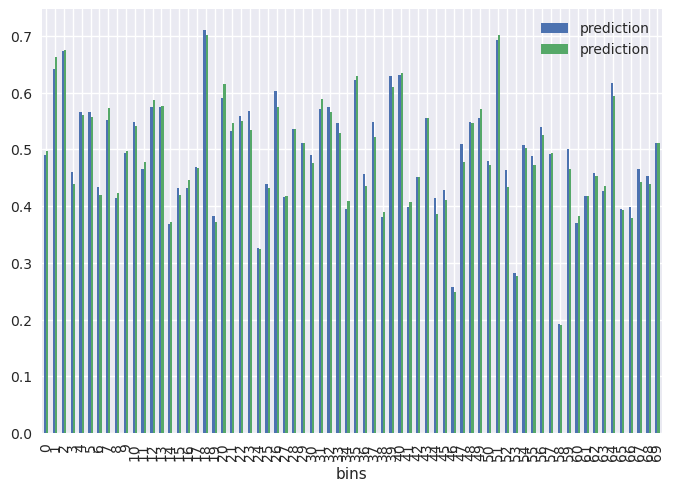

In [32]:
bins=70

auc819 = pd.read_csv('../LGBM/output/12_05_Mon_LGBM_elo만_추가_lr_0_023_피처_32개.csv')
auc819['bins'] = pd.cut(auc819.index,bins)
bins_map = {k:v for v,k in enumerate(sorted(auc819.bins.unique()))}
auc819['bins'] = auc819.bins.map(bins_map)
auc819_grp = auc819.groupby('bins').prediction.mean()

user_dfc2 = pd.read_csv('../LGBM/output/12_06_Tue_LGBM_ass_difficulty_pb_num_dificulty_제외_lr_0_023_피처_31개.csv')
user_dfc2['bins'] = pd.cut(user_dfc2.index,bins)
bins_map = {k:v for v,k in enumerate(sorted(user_dfc2.bins.unique()))}
user_dfc2['bins'] = user_dfc2.bins.map(bins_map)
user_dfc2_grp = user_dfc2.groupby('bins').prediction.mean()
pd.concat([auc819_grp,user_dfc2_grp],axis=1).plot(kind='bar')

In [40]:
test_idx = df2[df.answerCode==-1].index

In [41]:
test_idx

Int64Index([   2989,    3660,   10860,   15278,   23531,   26895,   39887,
              47628,   51927,   57352,
            ...
            2525476, 2525493, 2525558, 2525712, 2525876, 2525938, 2526081,
            2526282, 2526297, 2526675],
           dtype='int64', length=744)

In [42]:
df2.loc[df2.answerCode==-1,'answerCode'] = list(user_dfc2.prediction)

In [43]:
df2.iloc[test_idx,:]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,kind,uidIdx,assIdx,testIdx,...,pb_num_acc_mean,pb_num_difficulty,pb_num_acc_std,assess_count,left_asymptote,eloTest,elo,elo4,elo5,elo_pbnum0
2989,3,A050133008,A050000133,0.672018,2020-10-26 13:13:57,5289,test,3,4965,914,...,0.455696,0.544304,0.498037,0,0,0.594767,0.452318,0.269916,0.309847,0.417194
3660,4,A070146008,A070000146,0.758044,2020-12-27 02:47:54,9080,test,4,7748,1306,...,0.455696,0.544304,0.498037,0,0,0.672767,0.484820,0.349572,0.378067,0.488765
10860,13,A070111008,A070000111,0.273362,2020-12-27 04:35:09,9660,test,13,7484,1271,...,0.455696,0.544304,0.498037,0,0,0.268039,0.184150,0.050480,0.077037,0.345447
15278,17,A090064006,A090000064,0.834273,2020-10-30 05:48:37,2611,test,17,9381,1526,...,0.556891,0.443109,0.496754,0,0,0.593638,0.372931,0.058355,0.109558,0.751052
23531,26,A060135007,A060000135,0.300168,2020-10-23 11:44:18,1422,test,26,6231,1109,...,0.515853,0.484147,0.499750,0,0,0.736493,0.330752,0.059473,0.113720,0.526749
26895,29,A020190005,A020000190,0.859039,2020-10-22 04:38:45,8097,test,29,1967,380,...,0.599375,0.400625,0.490026,0,0,0.927748,0.898867,0.858973,0.867325,0.770413
39887,45,A040136005,A040000136,0.084882,2020-10-23 08:24:19,2107,test,45,3759,719,...,0.599375,0.400625,0.490026,0,0,0.717696,0.668842,0.512408,0.549739,0.577908
47628,53,A040140005,A040000140,0.066660,2020-10-26 09:13:20,2110,test,53,3779,723,...,0.599375,0.400625,0.490026,0,0,0.367120,0.074495,0.010277,0.017889,0.174486
51927,58,A070159007,A070000159,0.173516,2020-12-24 21:09:29,9122,test,58,7847,1319,...,0.515853,0.484147,0.499750,0,0,0.221155,0.115815,0.017567,0.033030,0.189909
57352,64,A070146008,A070000146,0.951520,2020-12-29 04:30:22,9080,test,64,7748,1306,...,0.455696,0.544304,0.498037,0,0,0.886088,0.819252,0.721230,0.745474,0.779199


## 기존 test -1일 때 elo

In [19]:
cond1 = df2.kind=='test'
cond2 = df2.userID != df2.userID.shift(-7)

In [28]:
base = ['userID', 'assessmentItemID', 'answerCode', 'Timestamp','KnowledgeTag']
add_features = ['elo','elo4','elo5','elo_pbnum0']
cols = base + add_features
df2[cond1 & cond2][cols]

,userID,assessmentItemID,answerCode,Timestamp,KnowledgeTag,elo,elo4,elo5,elo_pbnum0
2983,3,A050133002,1,2020-10-26 13:09:28,5288,0.571022,0.426416,0.458380,0.661011
2984,3,A050133003,1,2020-10-26 13:10:22,5289,0.500998,0.328790,0.366888,0.620320
2985,3,A050133004,1,2020-10-26 13:12:11,5289,0.658981,0.537985,0.564869,0.586131
2986,3,A050133005,1,2020-10-26 13:12:36,5288,0.751907,0.696667,0.704593,0.497482
2987,3,A050133006,1,2020-10-26 13:12:52,5288,0.574844,0.427521,0.460147,0.481934
2988,3,A050133007,0,2020-10-26 13:13:11,5289,0.279748,0.101631,0.135004,0.431756
2989,3,A050133008,-1,2020-10-26 13:13:57,5289,0.452318,0.269916,0.309847,0.417194
3654,4,A070146002,1,2020-12-27 02:45:13,9080,0.713866,0.667231,0.670432,0.722552
3655,4,A070146003,0,2020-12-27 02:45:46,9080,0.635181,0.528326,0.549767,0.685737
3656,4,A070146004,1,2020-12-27 02:46:11,9079,0.346269,0.138233,0.180370,0.654154


In [57]:
df2[(df2.userID==7329)][cols]

,userID,assessmentItemID,answerCode,Timestamp,KnowledgeTag,assess_count,past_ass_correct
2524735,7329,A040198001,0,2020-01-02 12:50:41,2133,0,0.0
2524736,7329,A040198002,1,2020-01-02 12:50:46,2133,0,0.0
2524737,7329,A040198003,1,2020-01-02 12:50:56,2133,0,0.0
2524738,7329,A040198004,1,2020-01-02 12:51:04,2133,0,0.0
2524739,7329,A010014001,1,2020-01-05 03:56:54,5834,0,0.0
2524740,7329,A010014002,1,2020-01-05 03:57:18,5834,0,0.0
2524741,7329,A010014003,1,2020-01-05 03:57:36,5834,0,0.0
2524742,7329,A010014004,1,2020-01-05 03:58:20,5834,0,0.0
2524743,7329,A010014005,1,2020-01-05 03:58:39,5834,0,0.0
2524744,7329,A040196001,1,2020-10-07 10:30:54,2131,0,0.0


## 내보내기

In [45]:
df2.sort_values(by=['userID','Timestamp'], inplace=True)

In [29]:
export(df2, output='lgbm_elo.pkl')

Write: /opt/ml/input/data/lgbm_elo.pkl
